In [26]:
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm

eval cumulative reward:  92.4081 (init:  92.4081), eval step-count: 9, average reward= 9.1905 (init= 9.0759), step count (max): 25, lr policy:  0.0003:   8%|▊         | 4000/50000 [00:39<04:33, 168.20it/s]

In [27]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

## Define Hyperparameters

In [28]:
device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells = 256  # 레이어 당 셀의 개수
lr = 3e-4
max_grad_norm = 1.0 # 그래디언트 클리핑을 위한 최대 그래디언트 norm

### Data collection parameters


In [29]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
total_frames = 50_000 // frame_skip # 총 학습할 프레임 수

### PPO parameters


In [30]:
sub_batch_size = 64  # 내부 루프(inner loop)에서 현재 데이터로부터 수집되는 서브 샘플의 기수(cardinality)
num_epochs = 10  # 최적화 단계를 몇 번 반복할지
clip_epsilon = (
    0.2  # clip value for PPO loss
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

## Define an environment


In [31]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

### Normalization

In [32]:
env = TransformedEnv(
    base_env,
    Compose(
        # 관측값 정규화
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(), # 환경이 종료되기 전까지 단계 카운트
    ),
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
# reduce_dim : 정규화를 적용할 차원 지정, 0으로 설정 -> 첫 번째 차원
# cat_dim=0 : 연속적인 데이터를 이어붙일 차원, 0으로 설정 -> 첫 번째 차원

In [34]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [35]:
print("observation_spec:", env.observation_spec) # 환경의 관측값에 대한 정보
print("reward_spec:", env.reward_spec) # 환경의 보상에 대한 정보
print("input_spec:", env.input_spec) # 환경의 입력에 대한 정보
print("action_spec (as defined by input_spec):", env.action_spec) # 환경의 행동에 대한 정보

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([11]), space=None, device=cuda:0, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)), device=cuda:0, dtype=torch.int64, domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cuda:0, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: BoundedTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(

In [36]:
check_env_specs(env) # 환경의 스펙이 올바르게 설정되었는지 확인

check_env_specs succeeded!


In [37]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)
# next는 현재 단계 이후에 오는 데이터

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
            batch_size=torch.Size([3]),
            device=cuda:0,
            is_shared=True),
        observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([3, 1]), devi

## Policy

In [38]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(), # 위치(loc)와 스케일(scale) 추출
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [39]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [40]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True, # 로그 확률값을 반환할지 여부
    # 중요도 가중치의 분자 부분에 로그 확률값이 필요함
)

## Value network

In [41]:
# 환경의 관측값을 입력으로 받아 예상 리턴 값을 출력
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"], # 관측값을 입력으로 받음
)

In [42]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), de

## Data collector

In [43]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch, # 각 반복마다 수집할 프레임 수
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

## Replay buffer


In [44]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(), # 같은 항목이 중복되지 않고 샘플링
)

## Loss function

In [45]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

/usr/local/lib/python3.10/dist-packages/torchrl/objectives/ppo.py:163: DeprecationWarning: Passing gamma / lambda parameters through the loss constructor is deprecated and will be removed soon. To customize your value function, run `loss_module.make_value_estimator(ValueEstimators.<value_fun>, gamma=val)`.
  warnings.warn(_GAMMA_LMBDA_DEPREC_WARNING, category=DeprecationWarning)


## Training loop

In [46]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip) # 진행 상황 파악
eval_str = "" # 평가 결과 문자열 저장

# collector를 total_frames로 지정된 총 프레임 수에 도달할 때까지 반복
for i, tensordict_data in enumerate(collector):
    for _ in range(num_epochs):
        # PPO를 작동시키기 위해 어드밴티지 신호가 필요함
        # 각 에포크마다 어드밴티지를 다시 계산함
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # 최적화: 역전파, 그래디언트 클리핑, 최적화 단계
            loss_value.backward()
            # 그래디언트 크기 제한은 필수적인 것은 아니지만, 그래디언트 크기를 제한하는 것이 좋음
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # 매 10 배치마다 정책 평가
        # 평가 방식 : 탐색 없이 정책을 실행하여 (행동 분포의 기대값을 사용) 주어진 스텝 수 동안 실행
        # env의 rollout 메서드는 정책을 인자로 받아서 각 단계에서 이 정책을 실행함
        with set_exploration_mode("mean"), torch.no_grad():
            # 훈련된 정책으로 롤아웃 실행
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    scheduler.step()


eval cumulative reward:  92.4081 (init:  92.4081), eval step-count: 9, average reward= 9.1905 (init= 9.0759), step count (max): 25, lr policy:  0.0003:   8%|▊         | 4000/50000 [00:48<09:19, 82.23it/s] 

  2%|▏         | 1000/50000 [00:08<06:32, 124.94it/s]/usr/local/lib/python3.10/dist-packages/tensordict/nn/probabilistic.py:79: DeprecationWarning: set_interaction_mode is deprecated for naming clarity. Please use set_interaction_type with InteractionType enum instead.
  _insert_interaction_mode_deprecation_warning("set_")

eval cumulative reward:  110.9682 (init:  110.9682), eval step-count: 11, average reward= 9.0762 (init= 9.0762), step count (max): 15, lr policy:  0.0003:   2%|▏         | 1000/50000 [00:08<06:32, 124.94it/s]
eval cumulative reward:  110.9682 (init:  110.9682), eval step-count: 11, average reward= 9.0762 (init= 9.0762), step count (max): 15, lr policy:  0.0003:   2%|▏         | 1000/50000 [00:21<06:32, 124.94it/s]
eval cumulative reward:  110.9682 (init:  110.96

## Results

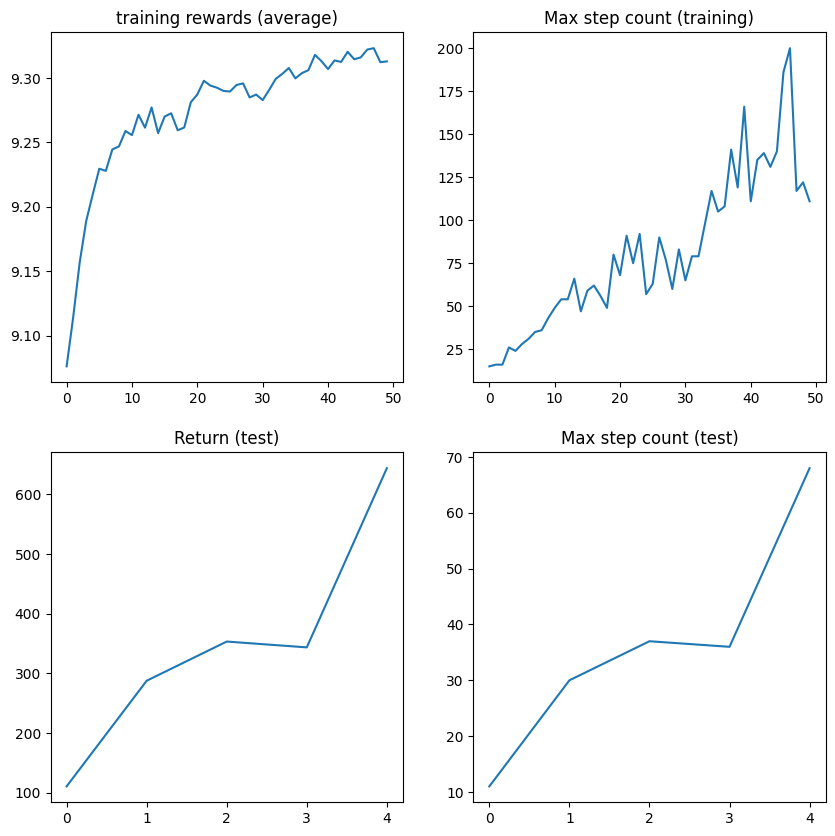

In [47]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()